# Final Project
Class: CSPB 3202
Author: Sara Rhoades
Semester: Summer 2024

In [1]:
from collections import namedtuple
partition = namedtuple("partition", ["type", "subtype"])
from IPython import display
import gym 
from gym.spaces.discrete import Discrete
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Three agents were built and compared against each other for a classical control problem. These agents are then contrasted against each other with respect to solution to the control problem, adaptability, and programming efficiency.

## Approach
The approach is split into three sections - about the enviornment, about the agents, and training the agents in the environment.

### Set up and Learn about the environment

Setup of this environment requires additional installs (pip install gymnasium[classic-control]) in additional to those described in RLenvsetup.md, which was provided with the project and repeated in the appendix.

From the documentation of the environment: "The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. This version is the one with discrete actions." (ref 1).

In [2]:
# Chosen problem
env = gym.make("MountainCar-v0")

The avaliable observation is a ndarray with shape (2,) where the elements correspond to the position of the car along the x-axis (in meters) and the velocity of the car (in m/s). X-position is limited to between -1.2 and +0.6 meters, with velocity limited to between -0.07 and +0.07 m/s. The car follows a set of dynamical equation for position and velocity which take into account the accelarative force applied by the controlling agent.

In [3]:
# Our starting state
env.reset()

(array([-0.5879844,  0.       ], dtype=float32), {})

There are three discrete deterministic actions that the agent can take:

0: Accelerate to the left

1: Don’t accelerate

2: Accelerate to the right

In [4]:
# Our possible actions
env.action_space

Discrete(3)

The environment provides rewards for reaching a goal in the top right of the game environment. It also has a cost of living to encourage reaching the goal in a timely manner. Should the car not reach the goal within 200 steps, the episode will time out.

### Set up the Agent

Five agents were created and trained - a random agent, a reflex agent with a set policy, and a trio of learning agents - one with default hyperparameters and no decay, one with default hyperparameters and exploration decay, and one with tuned hyperparameters. They are all created as methods under the class *Agent* and as such share some base functionality.

These five agents show a progression of model improvements that might be made by a new user to reinformcement learning and represent models of increasing complexity and usability.

The random agent simply chooses one of the avaliable actions at random.

The reflex agent has a set policy. Depending on the sign of both position and velocity, it decides whether to accelarate and in which direction. The actions were determined by the developer using intuitive logic as follows: Take advantage of the conversion of potential to kinetic energy and always accelerate when going up a hill - to the left of on the left hill and to the right if on the right hill. Accelerate right if going down the left hill and do not accelerate in either direction if going down the right hill.

The learning agents apply a Q-learning algorithm to determine the best policy for control of the car. The default learning agent uses hyperparameters of:
- learning rate = 0.01
- exploration rate = 0.5
- exploration rate decay = 0.0

A second version includes decay and has hyperparameters of:

- learning rate = 0.01
- exploration rate = 0.5
- exploration rate decay = 0.001

A final tuned version of the learning agent was created by manually adjusting the hyperparameters to find an improved model. This version has hyperparameters of:

- learning rate = 0.01
- exploration rate = 0.1
- exploration rate decay = 0.01

In [5]:
class Agent:
    def __init__(self,alpha=0.01,epsilon=0.5,decay=0.0):
        self.env = gym.make("MountainCar-v0")
        self.state = self.env.reset()
        self.weights = {}
        self.rewards = []
        self.steps = []
        self.policy = []
        self.alpha = alpha
        self.epsilon = epsilon
        self.decay = decay
        self.discount = 1.0
        self.validActions = [0,1,2]
        
    # Getters and Setters----------------------------
        
    def getWeights(self):
        return self.weights
    
    def setWeights(self,feature,weight):
        self.weights[feature] = weight
        
    def getRewards(self):
        return self.rewards
    
    def setRewards(self,total):
        self.rewards = total
        
    def getSteps(self):
        return self.steps
    
    def setSteps(self,step):
        self.steps = step
        
    def getPolicy(self, state):
        return self.computeActionFromQValues(state)
    
    def setPolicy(self, policy):
        self.policy = policy
    
    def getLearningRate(self):
        return self.alpha
    
    def setLearningRate(self,alpha):
        self.alpha = alpha
        
    def getExplorationRate(self):
        return self.epsilon
    
    def setExplorationRate(self,epsilon):
        self.epsilon = epsilon
        
    def getDecayRate(self):
        return self.decay
    
    def setDecayRate(self,decay):
        self.decay = decay
        
    def getDiscount(self):
        return self.discount
    
    def setDiscount(self,discount):
        self.discount = discount

    def getValue(self, state):
        return self.computeValueFromQValues(state)
    
    def setValue(self, state, action, value):
        self.qValue[(state,action)] = value
        return
    
    # Functions--------------------------------------
        
    def select_action(self, state, action):  
        return action
    
    def update(self, state, action, nextState, reward):
        return

    def play_episode(self, env):
        total_reward = 0.0
        state = env.reset()
        action = random.choice(self.validActions)
        steps = 0
        actions = []
        isInit = 1
        while True:
            if isInit:
                state = state[0]
                isInit = 0
            action = self.select_action(state, action)
            new_state, reward, is_done, _, _ = env.step(action)
            self.update(state, action, new_state, reward)
            total_reward += reward
            steps +=1
            actions.append(action)
            if is_done:
                break
            state = new_state
        return total_reward, steps, actions
    
    def repeat(self,n_sample):
        rewards =[]
        steps=[]
        policy = []
        for i in range(n_sample):
            reward, step, actions = self.play_episode(self.env)
            rewards.append(reward)
            steps.append(step)
            policy.append(actions)
        self.setRewards(rewards)
        self.setSteps(steps)
        self.setPolicy(policy)
        
# Class Extentions-----------------------------------
        
class RandomAgent(Agent):
    # This agent acts randomly
    def select_action(self,state,action):  
        return env.action_space.sample()
    
class ReflexAgent(Agent):   
    # This agent has a build in (hard-coded) set of rules (policy)
    def select_action(self, state, action):  
        if state[0] < 0:
            if state[1] < 0:
                action = 1
            else:
                action = 2
        else:
            if state[1] < 0:
                action = 0
            else:
                action = 2
        return action 
            
class LearningAgent(Agent): 
    # This agent learns it's own policy from experience
    def select_action(self, state, action):
        # Exploration
        if (random.random()<self.getExplorationRate()):
            # Act Randomly
            action = env.action_space.sample()
        # Exploitation
        else:
            # Chose action from State using Policy
            action = self.computeActionFromQValues(state)
        return action
    
    def computeValueFromQValues(self, state):
        """
          Returns max_action Q(state,action)
          where the max is over legal actions.  Note that if
          there are no legal actions, which is the case at the
          terminal state, you should return a value of 0.0.
        """
        (bestAction,bestValue) = self.computeBestFromQValues(state)
        return bestValue

    def computeActionFromQValues(self, state):
        """
          Compute the best action to take in a state.  Note that if there
          are no legal actions, which is the case at the terminal state,
          you should return None.
        """
        (bestAction,bestValue) = self.computeBestFromQValues(state)
        return bestAction
    
    def computeBestFromQValues(self, state):
        bestAction = None
        bestValue = float('-inf')
        for action in self.validActions:
            # Use approx RL to get values
            value = self.getQValue(state,action)
            if (value > bestValue):
                bestAction = action
                bestValue = value
            # If exact same value, break ties randomly for better behavior
            elif (value == bestValue):
                if (random.random()<0.5):
                    bestAction = action
                    bestValue = value
        return (bestAction,bestValue)
    
    def getFeatures(self, state, action):
        # X-Position, X-Velocity, X-acceleration
        features = {}
        features["pos"] = state[0]
        features["vel"] = state[1]
        features["acc"] = action
        return features

    def getQValue(self, state, action):
        """
          Should return Q(state,action) = w * featureVector
          where * is the dotProduct operator
        """
        Q = 0.0
        features = self.getFeatures(state,action)
        weights = self.getWeights()
        for feature in features:
            if feature in weights.keys():
                weight = weights[feature]
            else:
                weight = 0.0
            Q = Q + weight*features[feature]
        return Q
    
    def update(self, state, action, nextState, reward):
        """
           Should update your weights based on transition
        """
        oldValue = self.getQValue(state,action)
        nextBestValue = self.getValue(nextState)
        newValue = reward + (self.getDiscount()*nextBestValue) - oldValue
        
        features = self.getFeatures(state,action)
        weights = self.getWeights()
        for feature in features:
            if feature in weights.keys():
                oldWeight = weights[feature]
            else:
                oldWeight = 0.0
            updateValue = oldWeight + self.getLearningRate()*(newValue)*features[feature]
            self.setWeights(feature,updateValue)
            
        self.setExplorationRate(max(0.1,self.getExplorationRate()-self.getDecayRate()))
        return

### Teach the Agents

In training the agents, each is given a set number of experiences from which to learn. Since the random and reflex agents do not change their policies based upon learning, this is used solely to get an average of scores for these agents. The learning agents do learn with each new experience and so improve their scores with time.

In [6]:
numberGames = 200
tic = time.perf_counter()
rda = RandomAgent()
rda.repeat(numberGames)
rewards1 = rda.rewards
toc = time.perf_counter()
print(f"Trained Random Agent in {toc - tic:0.4f} seconds")

Trained Random Agent in 253.7249 seconds


The random agent can be shown to frequently not reach the goal and time out of the episode, and is the longest agent to train. Between this behavior and the fact that the model is never improving it's policy, the number of episodes for this agent was limited to keep processing time reasonable.

In [7]:
numberGames = 1000
tic = time.perf_counter()
ra = ReflexAgent()
ra.repeat(numberGames)
rewards2 = ra.rewards
toc = time.perf_counter()
print(f"Trained Reflex Agent in {toc - tic:0.4f} seconds")

Trained Reflex Agent in 5.8152 seconds


The reflex agent is quick to complete all of it's episodes but does not actually perform any learning and is not adaptable to new environments. It's actions are tuned to this specific environment alone; that is, it is tuned to starting in the dip between two hills and trying to reach the top of the hill on the right. It is not extensible to different numbers of hills, which hill has the goal, or working in a three-dimensional space.

During development, it was found that the operating system upon which this was run had a limit in the number of episodes that could be run without creating runtime errors as the weights and Q-values were updated.
```
/tmp/ipykernel_271/1855195647.py:206: RuntimeWarning: overflow encountered in double_scalars
  Q = Q + weight*features[feature]
/tmp/ipykernel_271/1855195647.py:206: RuntimeWarning: invalid value encountered in double_scalars
  Q = Q + weight*features[feature]
/tmp/ipykernel_271/1855195647.py:215: RuntimeWarning: invalid value encountered in double_scalars
  newValue = reward + (self.getDiscount()*nextBestValue) - oldValue
  ```
At around 120 episodes, the weights for the default Q-learning agent are of a magnitide of approxemately 1e230 to 1e280 when the overflow limit for doubles in python is (-1.79769313486e+308, 1.79769313486e+308). This indicates that the weights are unbounded and continually increasing (or decreasing) to infinity. The number of episodes used for training was reduced to keep away from this limit.

In [8]:
numberGames = 100
tic = time.perf_counter()
la = LearningAgent()
la.repeat(numberGames)
rewards3 = la.rewards
toc = time.perf_counter()
print(f"Trained Learning Agent in {toc - tic:0.4f} seconds")

Trained Learning Agent in 14.3193 seconds


In [9]:
print("Weights:",la.getWeights())

Weights: {'pos': -2.426204131236593e+147, 'vel': -1.0676577319494945e+145, 'acc': 1.7927633870526947e+147}


The tuned Q-learning agent does not have the same overflow problems that the default learning agent does. Even just the inclusion of a small decay term (say 0.001) keeping all other aprameters the same signifigantly limits the weights that the model determines. This indicates that the overflow problem of the default model is due to the large amount of exploration that it continues to do thoughout all training episodes; the model is attempting to eliminate the errors associated with bad exploation choices and is unable to.

In [10]:
numberGames = 1000
tic = time.perf_counter()
lat1 = LearningAgent(0.01,0.5,0.001)
lat1.repeat(numberGames)
rewards4 = lat1.rewards
toc = time.perf_counter()
print(f"Trained Learning Agent in {toc - tic:0.4f} seconds")

Trained Learning Agent in 66.1428 seconds


In [11]:
print("Weights:",lat1.getWeights())

Weights: {'pos': 208.50357105925713, 'vel': 1582.17202571134, 'acc': 4.388410278787362}


When adjusting the decay and exploration rates, a grid of values in equal incriments was iterated and trained for a short length of episodes. Visualizing the maximum score that can be achieved from each individual model shows no obvious trend or outlier in selecting these parameters, but could be argued to have a slight preference for agents with lower exploration rates. Therefore a agent with a small exploration and small exploration decay was selected as the final tuned agent.

In [12]:
tic = time.perf_counter()
exploreInitial = np.zeros((10,9))
exploreDecay = np.zeros((10,9))
maxLearned = np.zeros((10,9))
for n in range(0,9,1):
    for m in range(1,9,1):
        numberGames = 200
        lat2 = LearningAgent(0.01,n/10,m/100)
        lat2.repeat(numberGames)
        rewards5 = lat2.rewards
        exploreInitial[n,m] = n/10
        exploreDecay[n,m] = m/100
        maxLearned[n,m] = max(rewards5)
toc = time.perf_counter()
print("Trained ", 72," Learning Agents in ", toc - tic," seconds")

Trained  72  Learning Agents in  1686.0898643303663  seconds


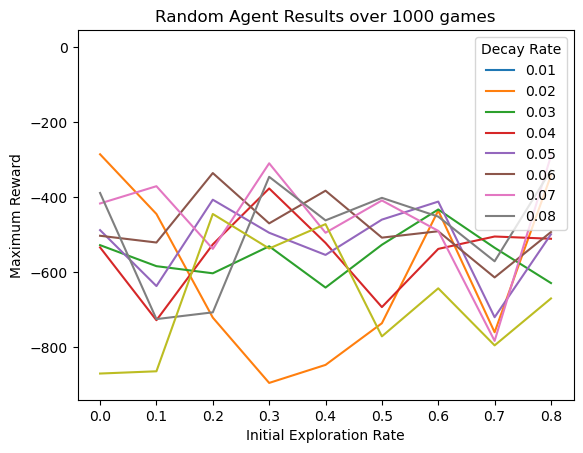

In [22]:
fig, axs = plt.subplots()
axs.plot(exploreInitial[0:9,],maxLearned[0:9,:])
axs.set(xlabel='Initial Exploration Rate', ylabel='Maximum Reward')
axs.set_title("Random Agent Results over "+ str(numberGames) +" games")
axs.legend(exploreDecay[1,1:9], title="Decay Rate", loc='upper right')

In [14]:
numberGames = 1000
tic = time.perf_counter()
lat2 = LearningAgent(0.01,0.1,0.01)
lat2.repeat(numberGames)
rewards5 = lat2.rewards
toc = time.perf_counter()
print(f"Trained Learning Agent in {toc - tic:0.4f} seconds")

Trained Learning Agent in 65.8804 seconds


In [15]:
print(lat2.getWeights())

{'pos': 177.9873782919948, 'vel': 1604.5062972689677, 'acc': 6.564027298904939}


The three Q-learning agents are both adaptable and moderately quick to train.

## Results

The first agent, that of the random actor, consistently shows a low reward for all experiences and does not improve with experience.

Mean: -38821.195 Std: 35926.415941991414 Max: -914.0


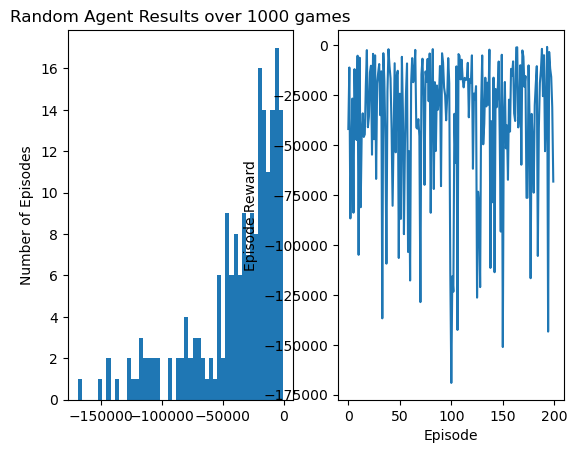

In [16]:
fig, axs = plt.subplots(1, 2)

axs[0].hist(rewards1,bins=50)
axs[0].set(ylabel='Number of Episodes')
axs[0].set_title("Random Agent Results over "+ str(numberGames) +" games")

axs[1].plot(rewards1)
axs[1].set(xlabel='Episode', ylabel='Episode Reward')

print("Mean:",np.mean(rewards1), "Std:", np.std(rewards1),"Max:", max(rewards1))

The relfex agent consistently shows a high reward. However, it is specific to this environment and has no adaptability to other environments.

Mean: -189.296 Std: 27.132349400669305 Max: -131.0


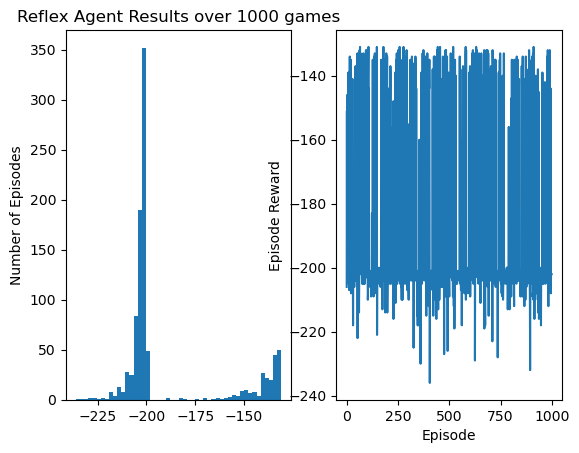

In [17]:
fig, axs = plt.subplots(1, 2)

axs[0].hist(rewards2,bins=50)
axs[0].set(ylabel='Number of Episodes')
axs[0].set_title("Reflex Agent Results over "+ str(numberGames) +" games")

axs[1].plot(rewards2)
axs[1].set(xlabel='Episode', ylabel='Episode Reward')

print("Mean:",np.mean(rewards2), "Std:", np.std(rewards2),"Max:", max(rewards2))

The default Q-learning agent with no decay shows an initial improvemnt over the early experiences but then plateues while still having a fairly large variance in reward due to the percentage of exploration (50%) that continues to happen. Becuase of this remaining large exploration, the weights given to the featues in the calculatio of Q-value continue to grow as the agent attempts to correct for this exploration but is unable to reduce the resulting errors.

Mean: -3192.82 Std: 2842.1733880254387 Max: -683.0


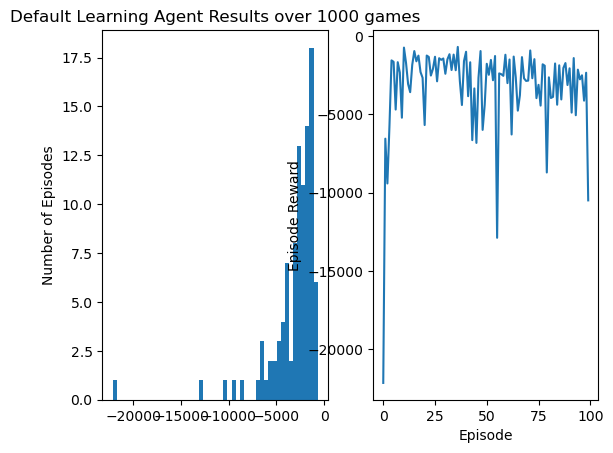

In [18]:
fig, axs = plt.subplots(1, 2)

axs[0].hist(rewards3,bins=50)
axs[0].set(ylabel='Number of Episodes')
axs[0].set_title("Default Learning Agent Results over "+ str(numberGames) +" games")

axs[1].plot(rewards3)
axs[1].set(xlabel='Episode', ylabel='Episode Reward')

print("Mean:",np.mean(rewards3), "Std:", np.std(rewards3),"Max:", max(rewards3))

The default learning agent with a small amount of decay shows similar early behavior to the previous learning agent but also shows a small but steady improvement of reward in the later experiences as the random exploration rate decreases.

Mean: -1445.689 Std: 1301.8750156136343 Max: -285.0


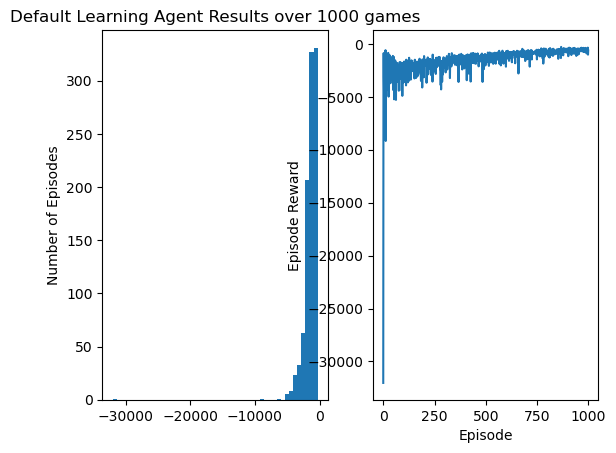

In [19]:
fig, axs = plt.subplots(1, 2)

axs[0].hist(rewards4,bins=50)
axs[0].set(ylabel='Number of Episodes')
axs[0].set_title("Default Learning Agent Results over "+ str(numberGames) +" games")

axs[1].plot(rewards4)
axs[1].set(xlabel='Episode', ylabel='Episode Reward')

print("Mean:",np.mean(rewards4), "Std:", np.std(rewards4),"Max:", max(rewards4))

The tuned agent shows a similar improvement even past the finitial quick increase in the early experiences. In contrast to the un-tuned learning agent, the rewards of the early experiences are higher but looking at the mean and maximum rewards over 1000 episodes shows little difference qualitative between the two.

Mean: -1445.401 Std: 1295.0677774537517 Max: -294.0


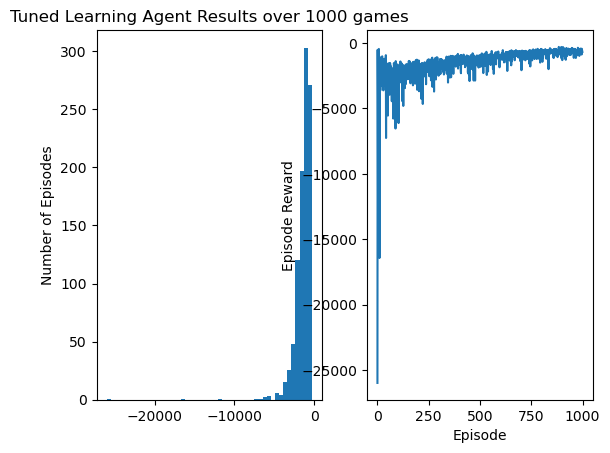

In [20]:
fig, axs = plt.subplots(1, 2)

axs[0].hist(rewards5,bins=50)
axs[0].set(ylabel='Number of Episodes')
axs[0].set_title("Tuned Learning Agent Results over "+ str(numberGames) +" games")

axs[1].plot(rewards5)
axs[1].set(xlabel='Episode', ylabel='Episode Reward')

print("Mean:",np.mean(rewards5), "Std:", np.std(rewards5),"Max:", max(rewards5))

## Conclusions

*Conclusion, discussion, reflection, or suggestions for improvements or ideas.*

 with respect to solution to the control problem, adaptability, and programming efficiency.

## Reference:

Git Location: https://github.com/smrhoades/cspb3202/tree/main

Video Location: https://github.com/smrhoades/cspb3202/tree/main/FinalProjectVideo_SRhoades.mv

1. Farama Foundation. 2023. https://gymnasium.farama.org/environments/classic_control/mountain_car/
2. CSPB 3202. Intro to Gym/Gymnasium.
3. Farama Foundation. 2023. https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/#sphx-glr-tutorials-training-agents-blackjack-tutorial-py
4. Geir Arne Hjelle. 2020. https://realpython.com/python-timer/#python-timers
5. StackOverflow. 2011. https://stackoverflow.com/questions/7559595/python-runtimewarning-overflow-encountered-in-long-scalars

## Appendix

### Setup Instructions [Ref 2]

The commands valid as of 04-10-2020

This additional package assumes you have other standard dependencies installed. If not and it causes error in the middle, please follow the message to troubleshoot or reach out to us for help.

This is for a local machine in a linux server, and has not been tested in the other system. If you use a VM service such as google colab and encounter a problem, please reach out to us.

Unless your project involves computer vision tasks and neural network models, you may not need a gpu machine, so you can still try in your local machine even if there is no (nvidia or compatible) gpu.

```
pip install -U pip

pip install -U torch torchvision ## caution: this is for linux. Windows' pip won't work and need conda: see https://pytorch.org/get-started/locally/

pip install gym

pip install atari-py

pip install opencv-python

pip install -U scipy

pip install -U tensorflow-gpu ## you won't need it if you don't have a gpu or in a colab environment where tensorflow-gpu is already available.

pip install -U tensorboard

```